In this notebook we will train `Logistic Regression`, `Random Forest` and `XGBoost` models. Becuase we just want to establish a baseline for the AUC metric, we only use the minimal dataset in `application_train.csv` and `application_test.csv` and do not tune the models' hyperparamters.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from _preprocessing import change_dtypes
from _preprocessing import deal_with_abnormal_days_employed
from _input_output import feature_importance_df
from _input_output import write_submit_csv

INP_DIR = "data/data_/"
SUBMIT_DIR = "data/submit_"

## Load data

In [2]:
X_train_0 = pd.read_csv(os.path.join(INP_DIR, "X_train_0.csv"))
X_train_0 = change_dtypes(X_train_0)

y_train = pd.read_csv(os.path.join(INP_DIR, "y_train.csv"))
y_train = y_train["TARGET"]

X_test_0 = pd.read_csv(os.path.join(INP_DIR, "X_test_0.csv"))
X_test_0 = change_dtypes(X_test_0)

id_test = pd.read_csv(os.path.join(INP_DIR, "id_test.csv"))

print("X_train_0 shape:", X_train_0.shape)
print("y_train shape:", y_train.shape)
print("X_test_0 shape:", X_test_0.shape)
print("id_test shape:", id_test.shape)

Memory usage before changing types 284.45 MB
Memory usage after changing types 128.24 MB
Memory usage before changing types 45.09 MB
Memory usage after changing types 20.33 MB
X_train_0 shape: (307511, 120)
y_train shape: (307511,)
X_test_0 shape: (48744, 120)
id_test shape: (48744, 1)


In [3]:
print("Percentage of positive lables: %0.5f" % (y_train == 1).mean())

Percentage of positive lables: 0.08073


## Missing value percentages

In [4]:
missing_vals = X_train_0.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
missing_vals.head(10)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
dtype: float64

In [5]:
print("Total number of columns", missing_vals.shape[0])
print("Number of columns having missing values:", (missing_vals > 0).sum())
print("Number of columns having more than 50% missing values:", (missing_vals > 0.5).sum())

Total number of columns 120
Number of columns having missing values: 67
Number of columns having more than 50% missing values: 41


`XGBoost` is able to work with missing values, so we may not need to impute. For other methods such as `Logistic Regression` or `Random Forest` we will need to impute missing values. 

## Histogram of numeric features

In [13]:
cols = X_train_0.select_dtypes("number").columns
len(cols)

99

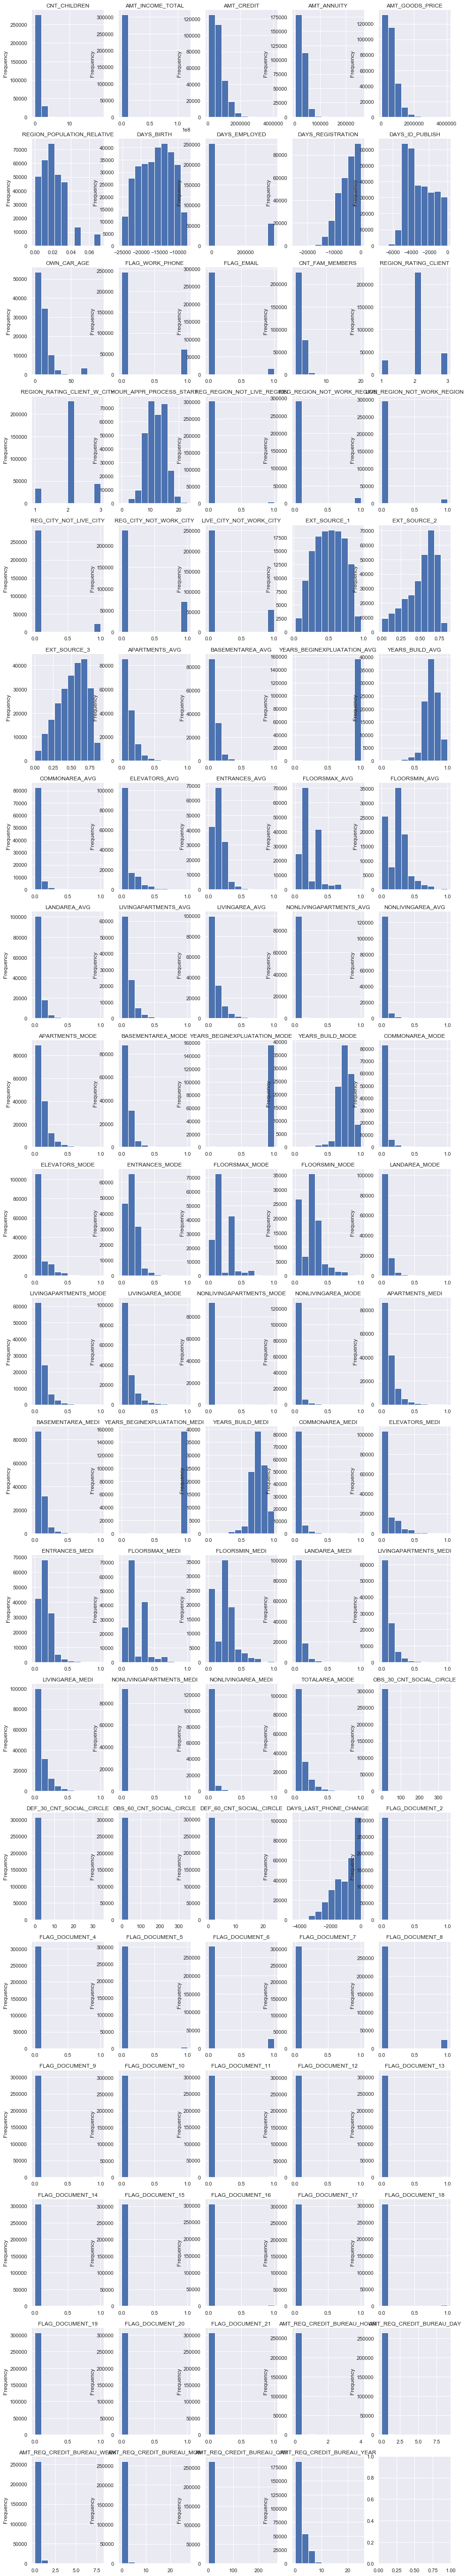

In [12]:
fig, axes = plt.subplots(nrows=20, ncols=5, figsize=(16, 100))
axes = axes.flatten()

for i, col in enumerate(cols):
    X_train_0[col].plot(kind="hist", ax=axes[i])
    axes[i].set_title(col)

The column `DAYS_EMPLOYED` is the number of days being employed up to the time of application. It is supposed to have negative values but the maximum is a very big positive number. This also happens with the test set. Let's look at the histogram. 

Thanks to Will Koehrsen for pointing out this in this Kaggle blog: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Text(0.5, 1.0, 'Test')

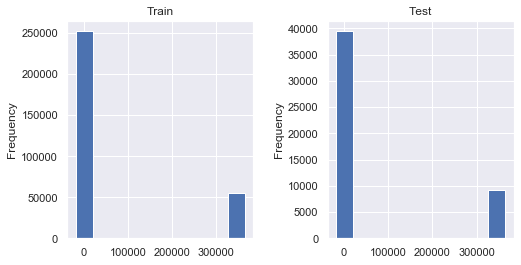

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.4)
X_train_0["DAYS_EMPLOYED"].plot(kind="hist", ax=ax[0])
ax[0].set_title("Train")

X_test_0["DAYS_EMPLOYED"].plot(kind="hist", ax=ax[1])
ax[1].set_title("Test")

In [10]:
default_pct_abnormal = y_train[X_train_0["DAYS_EMPLOYED"] == X_train_0["DAYS_EMPLOYED"].max()].mean()
default_pct_normal = y_train[X_train_0["DAYS_EMPLOYED"] != X_train_0["DAYS_EMPLOYED"].max()].mean()

print("Abnormal value:", X_train_0["DAYS_EMPLOYED"].max())
print("Default percent of abnormal: %0.5f" % default_pct_abnormal)
print("Default percent of normal: %0.5f" % default_pct_normal)

Abnormal value: 365243
Default percent of abnormal: 0.05400
Default percent of normal: 0.08660


So, whether `DAYS_EMPLOYED` is 365243 or not does affects the default rate. Let's turn the outlier into `nan` and add a column indicating whether it is outlier. Since we are going use it again, we will make a function in `_preprocessing.py`

In [11]:
X_train_0 = deal_with_abnormal_days_employed(X_train_0)
X_test_0 = deal_with_abnormal_days_employed(X_test_0)

## One hot encoding
When using `pd.get_dummies` to one-hot encode categorical features, missing values are assumed to belong to a new class.

In [12]:
X_train_0_ohe = pd.get_dummies(X_train_0)
X_test_0_ohe = pd.get_dummies(X_test_0)

print("X_train_0 shape", X_train_0.shape)
print("X_train_0_ohe shape", X_train_0_ohe.shape)

print("X_test_0 shape", X_test_0.shape)
print("X_test_0_ohe shape", X_test_0_ohe.shape)

X_train_0 shape (307511, 121)
X_train_0_ohe shape (307511, 245)
X_test_0 shape (48744, 121)
X_test_0_ohe shape (48744, 242)


`X_train_0_ohe` and `X_test_0_ohe` do not have the same shape. So we need to align them to make them have the same number of columns. The reason is the train and test sets don't have the same number of classes in one or more categorical columns. Here we have to reduce the number of columns of `X_train_0_ohe` such that it is the same as that of `X_test_0_ohe`. This may be a problem when we build an ML system in real life, where we don't have the test data at the time of training.

In [13]:
X_train_0_ohe, X_test_0_ohe = X_train_0_ohe.align(X_test_0_ohe, join='inner', axis=1)

print("X_train_0_ohe shape:", X_train_0_ohe.shape)
print("X_test_0_ohe shape:", X_test_0_ohe.shape)

X_train_0_ohe shape: (307511, 242)
X_test_0_ohe shape: (48744, 242)


Onehot encoding using `pd.get_dummies` and then aligning the train and test dataframes will be done repeatedly. We will make a function to do this in `preprocessing.py`.

## Impute missing values
Let's do the simplest imputation using the median.

In [14]:
imputer = Imputer(strategy="median")
imputer.fit(X_train_0_ohe)

X_train_0_imp = imputer.transform(X_train_0_ohe)
X_test_0_imp = imputer.transform(X_test_0_ohe)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Scale the features

In [15]:
std_scaler = StandardScaler()
std_scaler.fit(X_train_0_imp)

X_train_0_sca = std_scaler.transform(X_train_0_imp)
X_test_0_sca = std_scaler.transform(X_test_0_imp)

## Logistic Regression

In [160]:
cv = StratifiedKFold(n_splits=5, random_state=123)
cv_scores_lg = cross_val_score(LogisticRegression(), X_train_0_sca, y_train, scoring="roc_auc", cv=cv)
print("CV AUC of Logistic model: %0.5f +/- %0.5f" % (cv_scores_lg.mean(), cv_scores_lg.std()))

CV score of Logistic model: 0.74623 +/- 0.00286


## Random Forest

In [169]:
cv = StratifiedKFold(n_splits=5, random_state=123)
cv_scores_rf = cross_val_score(RandomForestClassifier(n_estimators=200, max_depth=5), X_train_0_sca, y_train, scoring="roc_auc", cv=cv)
print("CV AUC of RandomForest model: %0.5f +/- %0.5f" % (cv_scores_rf.mean(), cv_scores_rf.std()))

CV AUC of RandomForest model: 0.72087 +/- 0.00348


In [174]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5)
rf_model.fit(X_train_0_sca, y_train)

,feature,importance
28,EXT_SOURCE_2,0.193387
29,EXT_SOURCE_3,0.187715
27,EXT_SOURCE_1,0.075115
7,DAYS_EMPLOYED,0.062750
6,DAYS_BIRTH,0.040053
128,NAME_EDUCATION_TYPE_Higher education,0.028721
108,CODE_GENDER_M,0.025795
4,AMT_GOODS_PRICE,0.024404
77,DAYS_LAST_PHONE_CHANGE,0.022726
107,CODE_GENDER_F,0.019745


In [188]:
features = list(X_train_0_ohe.columns)
feature_importance = feature_importance_df(rf_model, features)
feature_importance.head(10)

,feature,importance
28,EXT_SOURCE_2,0.193387
29,EXT_SOURCE_3,0.187715
27,EXT_SOURCE_1,0.075115
7,DAYS_EMPLOYED,0.062750
6,DAYS_BIRTH,0.040053
128,NAME_EDUCATION_TYPE_Higher education,0.028721
108,CODE_GENDER_M,0.025795
4,AMT_GOODS_PRICE,0.024404
77,DAYS_LAST_PHONE_CHANGE,0.022726
107,CODE_GENDER_F,0.019745


## XGBoost

In [178]:
cv = StratifiedKFold(n_splits=5, random_state=123)
cv_scores_xgb = cross_val_score(XGBClassifier(), X_train_0_sca, y_train, scoring="roc_auc", cv=cv)
print("CV AUC of XGBoost model: %0.5f +/- %0.5f" % (cv_scores_xgb.mean(), cv_scores_xgb.std()))

CV AUC of XGBoost model: 0.75033 +/- 0.00284


In [176]:
xgb = XGBClassifier()
xgb.fit(X_train_0_sca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [189]:
feature_importance = feature_importance_df(xgb, features)
feature_importance.head(10)

,feature,importance
28,EXT_SOURCE_2,0.078798
29,EXT_SOURCE_3,0.070036
126,NAME_INCOME_TYPE_Working,0.054788
128,NAME_EDUCATION_TYPE_Higher education,0.053923
108,CODE_GENDER_M,0.050522
79,FLAG_DOCUMENT_3,0.038632
4,AMT_GOODS_PRICE,0.038616
7,DAYS_EMPLOYED,0.037543
131,NAME_EDUCATION_TYPE_Secondary / secondary special,0.034205
69,LIVINGAREA_MEDI,0.033213


## Write submission csv

In [190]:
write_submit_csv(xgb, X_test_0_sca, id_test, os.path.join(SUBMIT_DIR, "xgb_baseline.csv"))

Submitting this result to Kaggle gives an AUC of 0.73778.